# Data Preparation for Finals MVP

In this notebook we will prepare the data for the Finals MVP prediction.

#### Load Dependencies

In [15]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('..')

from data_scripts import _store_data as sd
from pathlib import Path

from sklearn.preprocessing import StandardScaler, LabelEncoder

sd.load_data(Path("../data"))

#### Copy and Prepare Player Data

This section prepares player performance statistics for Finals MVP analysis:

- **Copy Dataset:** Create a copy of the original player-team dataset to preserve the source data.  
- **Convert Key Stats to Float:** Ensure important performance statistics are numeric for accurate calculations.  
- **Aggregate by Player and Year:** Group the data by player and year, summing stats to get yearly totals per player.  
- **Add Season 11 Data:** Include additional data from Season 11 for completeness.  
- **Extract Team Info:** Get the primary team for each player per year.  
- **Sort Data:** Organize the data by player and year for performance computations.

In [16]:
finals_mvp_players_info_df = sd.players_teams_df.copy()

# Adding data from Season 11 before aggregation
players_teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/players_teams.csv")
finals_mvp_players_info_df = pd.concat([finals_mvp_players_info_df, players_teams_year11_df], ignore_index=True)

cols_to_agg = [
    'points', 'rebounds', 'assists', 'steals', 'blocks',
    'turnovers', 'fgMade', 'fgAttempted', 'GP', 'PF'
]

for col in cols_to_agg:
    finals_mvp_players_info_df[col] = finals_mvp_players_info_df[col].astype(float)

agg_df = finals_mvp_players_info_df.groupby(['playerID', 'year'])[cols_to_agg].sum().reset_index()

teams_info_df = finals_mvp_players_info_df.sort_values(
    ["playerID", "year", "stint"]
).drop_duplicates(
    subset=["playerID", "year"],
    keep="first"
)

teams_info_df = teams_info_df[['playerID', 'year', 'tmID']]

finals_mvp_players_info_df = agg_df.merge(teams_info_df, on=['playerID', 'year'], how='left')

finals_mvp_players_info_df = finals_mvp_players_info_df.sort_values(['playerID', 'year'])


#### Calculate Player Performance

This section computes individual player performance metrics:

- **Define Performance Function:** Create a function to calculate overall performance per game.  
- **Get Team Rosters:** Identify players on each team per year.  
- **Add Performance Features:** Calculate current and historical weighted performance scores.  
- **Handle Missing Data:** Fill in zeros for players with no prior history.

In [17]:
def overall_performance_per_game(PTS: float, REB: float, AST: float, 
                                STL: float, BLK: float, TOV: float,
                                FGM: float, FGA: float, GP: int) -> float:
    """Calculate overall performance score per game."""
    if GP == 0 or FGA == 0:
        return 0
    FG_percent = FGM / FGA
    return (
        (PTS / GP) +
        (REB / GP) * 1.2 +
        (AST / GP) * 1.5 +
        (STL / GP) * 3 +
        (BLK / GP) * 2 -
        (TOV / GP) * 2 +
        FG_percent * 10
    )

def get_team_rosters(players_df: pd.DataFrame) -> pd.DataFrame:
    """
    Get list of players on each team per year.
    
    Filters to stints 0 and 1 to get primary team assignments.
    """
    return (
        players_df
        .groupby(['tmID', 'year'])['playerID']
        .unique()
        .reset_index(name='players')
    )

def add_player_performance(players_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add performance metrics to player dataframe.
    """
    df = players_df.copy()

    # Calculate current performance
    df['Performance'] = df.apply(
        lambda row: overall_performance_per_game(
            row['points'], row['rebounds'], row['assists'], row['steals'],
            row['blocks'], row['turnovers'], row['fgMade'], 
            row['fgAttempted'], row['GP']
        ), axis=1
    )

    df = df.sort_values(['playerID', 'year'])

    # Calculate previous and weighted features
    df['PrevPerformance'] = df.groupby('playerID')['Performance'].shift(1)

    weights_dict = {
        '2yr': [0.7, 0.3],
        '3yr': [0.5, 0.3, 0.2],
        '4yr': [0.5, 0.25, 0.15, 0.10]
    }

    hist_features = ['Performance']

    for suffix, weights in weights_dict.items():
        for feat in hist_features:
            df[f"{feat}_weighted_{suffix}"] = sum(
                weights[i] * df.groupby('playerID')[feat].shift(i+1) for i in range(len(weights))
            )
    
    # SET FIRST YEAR TO 0 (NO HISTORY)
    df['PrevPerformance'] = df['PrevPerformance'].fillna(0)
    
    for suffix in weights_dict.keys():
        df[f"Performance_weighted_{suffix}"] = df[f"Performance_weighted_{suffix}"].fillna(0)

    # Now drop the current performance columns
    df.drop(columns=['Performance'], inplace=True)

    return df

finals_mvp_players_info_df = add_player_performance(finals_mvp_players_info_df)

#### Calculate Team Performance

This section aggregates player performance to the team level:

- **Team Player Performance:** Combine individual performances into team averages.  
- **Standardize Metrics:** Normalize performance features by year for comparability.  
- **Merge with Players:** Add team-level features back to the player dataframe.

In [18]:
def add_team_player_performance(players_teams_df: pd.DataFrame, 
                                teams_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate team-level aggregated player performance metrics.

    Aggregates individual player performance (including weighted historical features)
    to team level and standardizes metrics by year.
    """
    dfp = add_player_performance(players_teams_df)

    if 'tmID' in dfp.columns:
        dfp = dfp.drop(columns=['tmID'])

    roster = get_team_rosters(players_teams_df)
    exploded = roster.explode('players').rename(columns={'players': 'playerID'})

    merged = exploded.merge(dfp, on=['playerID', 'year'], how='left')

    performance_cols = [
        'PrevPerformance',
        'Performance_weighted_2yr',
        'Performance_weighted_3yr',
        'Performance_weighted_4yr'
    ]

    team_perf = merged.groupby(['tmID', 'year'])[performance_cols].mean().reset_index()

    df_out = teams_df.merge(team_perf, on=['tmID', 'year'], how='left')

    df_out[performance_cols] = df_out[performance_cols].fillna(0)

    for year in df_out['year'].unique():
        mask = df_out['year'] == year
        df_out.loc[mask, performance_cols] = StandardScaler().fit_transform(df_out.loc[mask, performance_cols])

    return df_out

team_score_df = add_team_player_performance(finals_mvp_players_info_df, sd.teams_df)

team_score_df = team_score_df[['year', 'tmID', 'PrevPerformance', 
                               'Performance_weighted_2yr', 
                               'Performance_weighted_3yr', 
                               'Performance_weighted_4yr']]

finals_mvp_players_info_df = finals_mvp_players_info_df.merge(
    team_score_df.rename(
        columns={c: f"team_{c}" for c in team_score_df.columns if c not in ['tmID', 'year']}
    ),
    on=['tmID', 'year'],
    how='left'
)

#### Merge Finals MVP Player Award Information

This step incorporates the target variable for modeling Finals MVP performance:

- **Filter Awards:** Identify WNBA Finals MVP awards from the awards dataset.  
- **Add Indicator:** Create a column marking winners (1) or non-winners (0).  
- **Merge with Players:** Combine award data with the player dataframe.  
- **Prepare for Modeling:** Ensure the dataset includes features and the target variable.

In [19]:
finals_mvp_aw = sd.awards_players_df[sd.awards_players_df['award'].str.strip().str.lower() == 'wnba finals most valuable player'].copy()
finals_mvp_aw['finals_mvp'] = 1

finals_mvp_players_info_df = finals_mvp_players_info_df.merge(
    finals_mvp_aw[['playerID', 'year', 'finals_mvp']],
    on=['playerID', 'year'],
    how='left'
)
finals_mvp_players_info_df['finals_mvp'] = finals_mvp_players_info_df['finals_mvp'].fillna(0).astype(int)

#### Remove Columns and Save CSV

This step finalizes the Finals MVP dataset:

- **Drop Unnecessary Columns:** Remove raw stats and redundant features.  
- **Save to CSV:** Export the processed dataset to a CSV file for predictive modeling.  
- **Ready for Analysis:** The dataset is now clean and contains features for Finals MVP prediction.

In [20]:
cols_to_drop = ['points', 'rebounds', 'assists', 'steals', 'blocks', 
                'turnovers', 'fgMade', 'fgAttempted', 'GP', 'PF', 'tmID']

finals_mvp_players_info_df = finals_mvp_players_info_df.drop(
    columns=[col for col in cols_to_drop if col in finals_mvp_players_info_df.columns]
)

finals_mvp_players_info_df.to_csv("../predict_datasets/finals_mvp.csv", index=False)

#### Idea For the Dataset Preparation

Since this dataset is for Finals most valuable player dataset, we calculated the overall performance score for each team, as the best teams have more chances to reach the finals. We also add the player score because the finals mvp need to be the best player on the finals to win the award.

#### Data Correlation Analysis

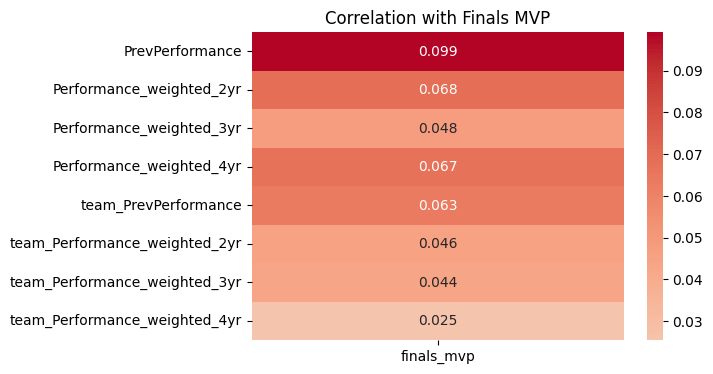

In [21]:
score_cols = ['PrevPerformance', 'Performance_weighted_2yr', 'Performance_weighted_3yr', 'Performance_weighted_4yr', 'team_PrevPerformance', 'team_Performance_weighted_2yr', 'team_Performance_weighted_3yr', 'team_Performance_weighted_4yr', 'finals_mvp']
df_scores = finals_mvp_players_info_df[score_cols]

corr_matrix = df_scores.corr()[['finals_mvp']]

corr_matrix = corr_matrix.drop('finals_mvp')

plt.figure(figsize=(6, len(corr_matrix)/2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Finals MVP")
plt.show()